## Aluno : Lucas Rodrigues Aragão (538390)

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import recall_score,precision_score, f1_score ,precision_recall_curve, roc_curve, auc, roc_auc_score



A imagem acima mostra bem como será feito o processo de ajuste de hiperparametros (mesmas funções usadas na lista 4, como pequenos ajustes)

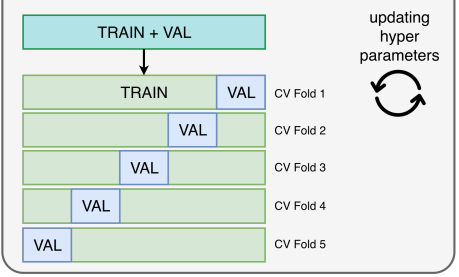

In [91]:
def test_hyperparameter_rec(hyperparameter_list, model, x_train, x_teste, y_train, y_teste, scaler_y = None, hyperparameter=0, hyperparameters_atuais=[]):
    """
    essa funcao calcula recursivamente as metricas de avaliacao para todas as combinacoes de hiperparametros possiveis e retorna elas em formato de lista
    
    """
    
    if len(hyperparameters_atuais) == len(hyperparameter_list):
        if isinstance(model, RandomForestClassifier):
            modelo = RandomForestClassifier(**dict(hyperparameters_atuais))
        else:
            modelo = SVC(**dict(hyperparameters_atuais))

        #print(f'hiperparametros atuais {hyperparameters_atuais}')
        modelo.fit(x_train, y_train)
        predictions = modelo.predict(x_teste)

        accuracy = np.mean(predictions == y_teste)
        return [[accuracy, hyperparameters_atuais]]  

    resultados = []
    for element in hyperparameter_list[hyperparameter][1]:
        hyperparameters_temp = hyperparameters_atuais + [(hyperparameter_list[hyperparameter][0], element)]
        res = test_hyperparameter_rec(hyperparameter_list, model, x_train, x_teste, y_train, y_teste, scaler_y, hyperparameter=hyperparameter + 1, hyperparameters_atuais=hyperparameters_temp)
        resultados.extend(res)  
    return resultados


def kfold_com_grid_search(model, features_data, label_data, hyperparameters_list, num_folds):
    """
    essa funcao calcula as avaliacoes para todas as combinacoes possiveis, variando os conjuntos de treino e validacao
    ao final ela retorna o modelo com o melhor conjunto de hiperparametros e o valor da metrica de avaliacao obtida
    """
    tamanho_particoes = int(np.ceil(len(features_data) / num_folds))

    lista_avaliacoes = []

    for i in range(num_folds):
        inicio = i * tamanho_particoes
        fim = min((i + 1) * tamanho_particoes, len(features_data))

        x_teste = features_data.iloc[inicio:fim]
        y_teste = label_data.iloc[inicio:fim]

        x_train_fold = features_data.drop(features_data.index[inicio:fim])
        y_train_fold = label_data.drop(label_data.index[inicio:fim])

        scaler_x = StandardScaler()
        x_train_fold_normalizado = pd.DataFrame(scaler_x.fit_transform(x_train_fold), columns=x_train_fold.columns, index=x_train_fold.index)
        x_train_fold = x_train_fold_normalizado.copy()
        x_teste_normalizado = pd.DataFrame(scaler_x.transform(x_teste), columns=x_teste.columns, index=x_teste.index)
        x_teste = x_teste_normalizado.copy()

        avaliacoes = test_hyperparameter_rec(hyperparameter_list=hyperparameters_list, model=model, x_train=x_train_fold, x_teste=x_teste, y_train=y_train_fold, y_teste=y_teste)

        lista_avaliacoes.extend(avaliacoes)

    combinacoes = {}

    for resultado in lista_avaliacoes:
        score, params = resultado
        params_tuple = tuple(params)  
        if params_tuple not in combinacoes:
            combinacoes[params_tuple] = []
        combinacoes[params_tuple].append(score)

    medias_comb = {param: np.mean(scores) for param, scores in combinacoes.items()}

    melhor_comb = max(medias_comb, key=medias_comb.get)  

    return melhor_comb, medias_comb[melhor_comb]


In [92]:
def plotar_roc_precrecall(y_teste, y_score):
    fpr, tpr, _ = roc_curve(y_teste, y_score)
    roc_auc = roc_auc_score(y_teste, y_score)
    precision, recall, _ = precision_recall_curve(y_teste, y_score)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precisão')
    plt.title('Curva Precision-Recall')
    plt.legend(loc='lower left')
    
    plt.tight_layout()
    plt.show()


## Questão 1

In [93]:
data = pd.read_csv('californiabin.csv')
data = data.sample(frac= 1).reset_index(drop= True)

train, test = train_test_split(data, test_size= 0.2)

X_train = train.iloc[:, :-1]
y_train = train.iloc[:,-1].astype('int')
X_teste = test.iloc[:, :-1]
y_teste = test.iloc[:, -1].astype('int')
y_teste = np.array(y_teste)

scaler_x = StandardScaler()
X_train_normalizado = pd.DataFrame(scaler_x.fit_transform(X_train), columns= X_train.columns)
X_teste_normalizado = pd.DataFrame(scaler_x.transform(X_teste), columns= X_teste.columns)

data

,col1,col2,col3,col4,col5,col6,col7,col8,label
0,3.5671,28.0,4.704953,1.037935,2273.0,2.395153,34.13,-118.08,1.0
1,4.6071,52.0,6.030189,1.075472,689.0,2.600000,37.75,-122.47,1.0
2,2.1518,43.0,3.728125,0.934375,1184.0,3.700000,34.23,-118.39,0.0
3,0.9220,15.0,6.287671,1.301370,160.0,2.191781,33.36,-115.91,0.0
4,3.4042,33.0,4.769363,1.134251,1496.0,2.574871,37.38,-122.08,1.0
...,...,...,...,...,...,...,...,...,...
1995,3.1779,17.0,4.787356,1.084291,781.0,1.496169,33.61,-117.75,1.0
1996,3.7449,6.0,5.237012,1.123658,5634.0,2.419064,38.63,-121.49,0.0
1997,3.0850,32.0,4.433962,1.009434,1404.0,3.311321,34.07,-118.13,1.0
1998,4.7500,21.0,4.602740,0.931507,206.0,2.821918,37.93,-121.22,0.0


### SVC

In [94]:
cs = []
for i in range(-5, 16):
    cs.append(2**i)
h1 = ("C", cs)

gammas = []
for i in range(-15,4):
    gammas.append(2**i)

h2 = ("gamma", gammas)

svc_hyperparameter_list = [h1, h2]

svm_best_hyperparameters, svm_best_accuracy = kfold_com_grid_search(model= SVC(), features_data= X_train, label_data= y_train, hyperparameters_list= svc_hyperparameter_list, num_folds= 10)

In [95]:
svm_best_accuracy

0.85375

In [96]:
svm_best_hyperparameters

(('C', 4), ('gamma', 0.5))

#### Usando o modelo com os melhores hiperparametros para o conjunto de teste

In [97]:
svm_best_hyperparameters = dict(svm_best_hyperparameters)
svm_best_hyperparameters['probability'] = True

svm_foda = SVC(**svm_best_hyperparameters)
svm_foda.fit(X_train_normalizado, y_train)

predictions_svm = svm_foda.predict(X_teste_normalizado)
svm_predicions_probabilities = svm_foda.predict_proba(X_teste)
svm_class_1 = svm_predicions_probabilities[:,1]

#### Cálculo das métricas

Acurácia

In [98]:
acuracia_svm = np.mean(predictions_svm == y_teste)
acuracia_svm

0.8525

Revocação

In [99]:
revocacao_svm = recall_score(y_teste, predictions_svm)
revocacao_svm

0.8556149732620321

Precisão

In [100]:
precisao_svm = precision_score(y_teste, predictions_svm)
precisao_svm

0.8333333333333334

F1-Score

In [101]:
f1_svm = f1_score(y_teste, predictions_svm)
f1_svm

0.8443271767810027

Curvas

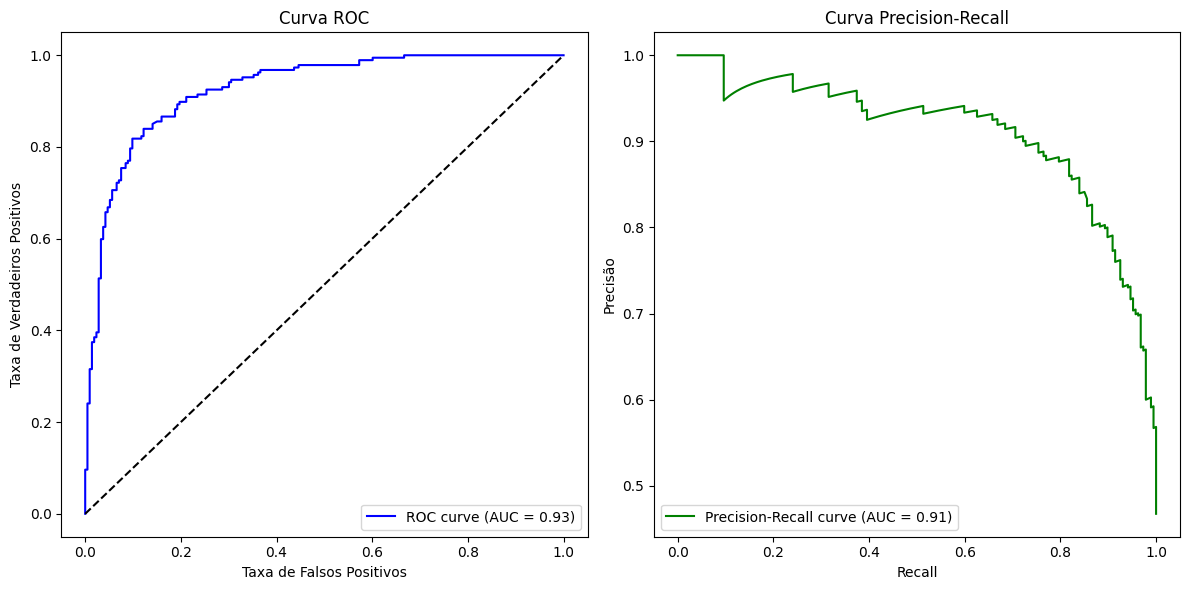

In [102]:
y_scores_svm = svm_foda.predict_proba(X_teste_normalizado)[:,1]
plotar_roc_precrecall(y_teste= y_teste, y_score= y_scores_svm)

### Random Forest

In [103]:
number_classifiers = []
for i in range(20):
    number_classifiers.append((i+1)*10)
h1_rf = ('n_estimators', number_classifiers)
h2_rf = ('max_depth', [4,6,8,10, None])

rf_hyperparameter_list = [h1_rf, h2_rf]

rf_best_hyperparameters, rf_best_acuracia = kfold_com_grid_search(model= RandomForestClassifier(), features_data= X_train, label_data= y_train, hyperparameters_list= rf_hyperparameter_list, num_folds= 10)


In [104]:
rf_best_acuracia

0.86875

In [105]:
rf_best_hyperparameters

(('n_estimators', 190), ('max_depth', 10))

#### Usando o modelo com os melhores hiperparametros para o conjunto de teste

In [106]:
rf_foda = RandomForestClassifier(**dict(rf_best_hyperparameters))
rf_foda.fit(X_train_normalizado, y_train)

predictions_rf = rf_foda.predict(X_teste_normalizado)
predicions_probabilities_rf = rf_foda.predict_proba(X_teste)
rf_class_1 = predicions_probabilities_rf[:, 1]

#### Cálculo das métricas

Acurácia

In [107]:
acuracia_rf = np.mean(predictions_rf == y_teste)
acuracia_rf

0.87

Revocação

In [108]:
revocacao_rf = recall_score(y_teste, predictions_rf)
revocacao_rf

0.8663101604278075

Precisão

In [109]:
precisao_rf = precision_score(y_teste, predictions_rf)
precisao_rf

0.8571428571428571

F1-Score

In [110]:
f1_rf = f1_score(y_teste, predictions_rf)
f1_rf

0.8617021276595744

Curvas

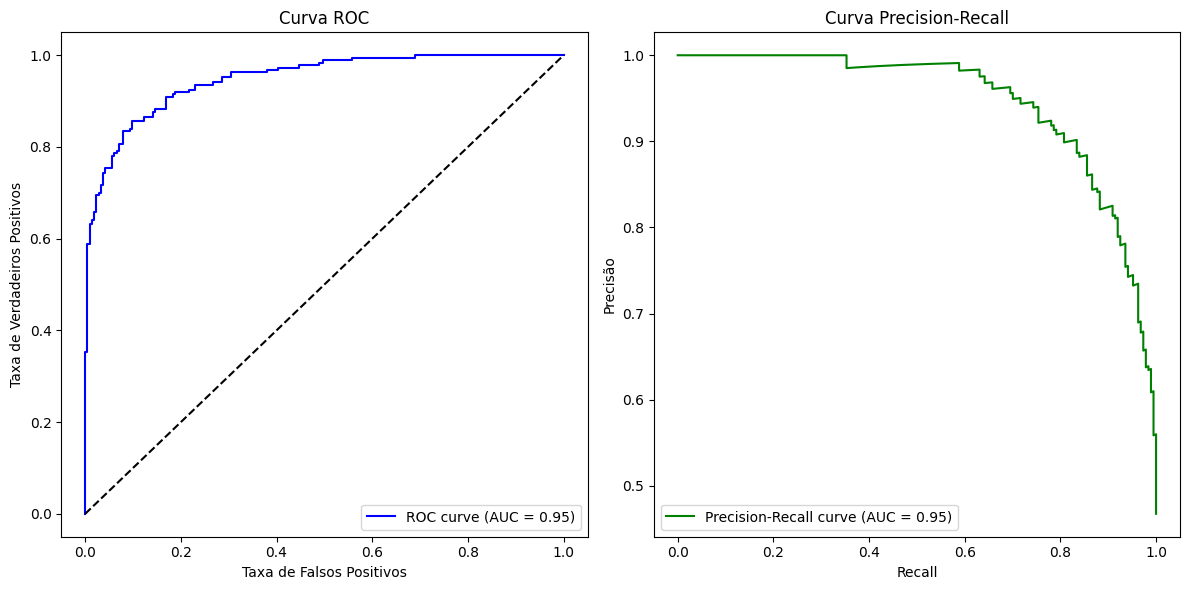

In [111]:
y_scores_rf = rf_foda.predict_proba(X_teste_normalizado)[:, -1]
plotar_roc_precrecall(y_teste= y_teste, y_score= y_scores_rf)